In [2]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rioxarray
from pyfixest.estimation import feols
from pyfixest.did.estimation import lpdid

from mpl_toolkits.axes_grid1 import make_axes_locatable


      You have loaded the 'pyfixest.did' module. While every function is tested in `tests/test_did.py`,
      the module is not yet as thoroughly tested as I would like. So please use it with caution and
      provide feedback in case you stumble over any bugs!
      


# Regression analysis for severity/intensity

In [3]:
def expand_grid(dict_vars):
    """Create cartesian product of a set of vectors and return a datafarme

    This function calculates the cartesian product of a set of vectors and
    return a tabular data structure, just as R's expand.grid function.
a
    Parameters
    ----------
    dict_vars : dict
        Dictionary containing the vectors to be combined. The keys are the
        column names and the values are the vectors.

    Returns
    -------
    pandas.DataFrame
        Dataframe containing the cartesian product of the vectors
    """
    mesh = np.meshgrid(*dict_vars.values())
    data_dict = {var: m.flatten() for var, m in zip(dict_vars.keys(), mesh)}

    return pd.DataFrame(data_dict)

### Build dataset for regression: 
 - Take template and remove water.
 - Do a cartesian product of pixel and year to have a balanced panel 
 - Select only land points in treatments data 

In [4]:
# Load template to start merging

template = rioxarray.open_rasterio(
    "/mnt/sherlock/oak/prescribed_data/geoms/templates/template.tif"
)

# Notice template is 1 for land and 0 for water
template_df = (
    template.rename({"x": "lon", "y": "lat"})
    .to_dataframe(name="id_template")
    .reset_index()
    .dropna()
)
template_df["grid_id"] = template_df.index

# Remove the water pixels
template_df = template_df[template_df.id_template == 1]

# Create grid for all years in the sample
template_expanded = expand_grid(
    {"grid_id": template_df.grid_id, "year": np.arange(2000, 2023)}
)

# Add lat and lon to the expanded grid
template_expanded = template_expanded.merge(
    template_df[["grid_id", "lat", "lon"]], on="grid_id"
)

# Load treatments and MTBS data
treatments = pd.read_feather(
    "/mnt/sherlock/oak/prescribed_data/processed/treatments_mtbs.feather",
).drop(columns=["spatial_ref"])

# # Remove all the prescribed fires and keep wildfires only
treatments = treatments[treatments.Incid_Type != "Prescribed Fire"]

# Merge with template to clean treatments (they're full of water!)
treatments = template_expanded.merge(treatments, on=["lat", "lon", "year"], how="left")

# Create treatments columns (both wildifre and prescribed are 1!)
treatments = treatments.assign(
    treat=np.select(
        [treatments["Event_ID"] == "nodata", treatments["Event_ID"].isna()],
        [0, 0],
        default=1,
    ),
)

In [5]:
treatments[treatments.grid_id == 24099]

,grid_id,year,lat,lon,Event_ID,Ig_Date,Incid_Name,Incid_Type,treat
170085,24099,2000,424152.596997,-90913.82085,nodata,NaT,None,None,0
170086,24099,2001,424152.596997,-90913.82085,CA4184912111220010703,2001-07-03,CLEAR,Wildfire,1
170087,24099,2002,424152.596997,-90913.82085,nodata,NaT,None,None,0
170088,24099,2003,424152.596997,-90913.82085,nodata,NaT,None,None,0
170089,24099,2004,424152.596997,-90913.82085,nodata,NaT,None,None,0
170090,24099,2005,424152.596997,-90913.82085,nodata,NaT,None,None,0
170091,24099,2006,424152.596997,-90913.82085,nodata,NaT,None,None,0
170092,24099,2007,424152.596997,-90913.82085,nodata,NaT,None,None,0
170093,24099,2008,424152.596997,-90913.82085,nodata,NaT,None,None,0
170094,24099,2009,424152.596997,-90913.82085,nodata,NaT,None,None,0


### Define treatment structure

To run the regression with distributed lags, we need to first find all the treatment counts
and then get a `year_to_treat` variable to use in the regression. We are going to filter for
only pixels that burned twice, rather than pixels that burned more than twice (the max is 9)

In [6]:
treatments["count_treats"] = treatments.groupby("grid_id").treat.transform("sum")

# Reduce sample! Only keep the pixels that have only one that treatments
# treatments = treatments[treatments.count_treats <= 2]

# Get the first year of treatment for each grid_id in the dataframe
min_years = (
    treatments[treatments.treat == 1]
    .groupby("grid_id", as_index=False)
    .year.min()
    .astype(int)
    .rename({"year": "min_treat_year"}, axis=1)
)

# Calculate relative year variable (year - min_year)
treatments = treatments.merge(min_years, on="grid_id", how="left")
treatments["rel_year"] = (treatments.year - treatments["min_treat_year"]).astype(float)

# Merge with land cover data
land_cover = pd.read_feather(
    "/mnt/sherlock/oak/prescribed_data/processed/land_type.feather"
).drop(columns=["spatial_ref", "band"])

# Merge with treatments
# Beware here: 453 grids don't have a land cover type
treatments = treatments.merge(land_cover, on=["lat", "lon"], how="left")

# Add ever treated to the dataframe
treatments["ever_treated"] = treatments.groupby("grid_id").treat.transform("max")

In [7]:
treatments[treatments.grid_id == 962484]

,grid_id,year,lat,lon,Event_ID,Ig_Date,Incid_Name,Incid_Type,treat,count_treats,min_treat_year,rel_year,land_type,ever_treated
9419328,962484,2000,-599847.403003,310086.17915,nodata,NaT,None,None,0,2,2005.0,-5.0,NaN,1
9419329,962484,2001,-599847.403003,310086.17915,nodata,NaT,None,None,0,2,2005.0,-4.0,NaN,1
9419330,962484,2002,-599847.403003,310086.17915,nodata,NaT,None,None,0,2,2005.0,-3.0,NaN,1
9419331,962484,2003,-599847.403003,310086.17915,nodata,NaT,None,None,0,2,2005.0,-2.0,NaN,1
9419332,962484,2004,-599847.403003,310086.17915,nodata,NaT,None,None,0,2,2005.0,-1.0,NaN,1
9419333,962484,2005,-599847.403003,310086.17915,CA3257711672220051005,2005-10-05,BORDER 50,Wildfire,1,2,2005.0,0.0,NaN,1
9419334,962484,2006,-599847.403003,310086.17915,nodata,NaT,None,None,0,2,2005.0,1.0,NaN,1
9419335,962484,2007,-599847.403003,310086.17915,nodata,NaT,None,None,0,2,2005.0,2.0,NaN,1
9419336,962484,2008,-599847.403003,310086.17915,nodata,NaT,None,None,0,2,2005.0,3.0,NaN,1
9419337,962484,2009,-599847.403003,310086.17915,nodata,NaT,None,None,0,2,2005.0,4.0,NaN,1


### Add DV data to the template/treaments dataset
- Add severity data to the template/treatments dataset
- Add intensity data to the template/treatments dataset

In [14]:
# Just take wildfires, because we don't have prescribed fire severity data
# We already remove them before, but we are being extra explicit here
wildfires = treatments[treatments.Incid_Type != "Prescribed Fire"]

# Load intensity FRP data
frp = pd.read_feather("/mnt/sherlock/oak/prescribed_data/processed/frp_concat.feather")
frp["year"] = frp.time.dt.year
frp_groupped = frp.groupby(["lat", "lon", "year"], as_index=False).frp.max()

# Find the FRP class from the earliest fire per each grid using the
# FRP threshold values (Ichoku et al. 2014):
conditions = [
    frp_groupped.frp < 100,
    (frp_groupped.frp >= 100) & (frp_groupped.frp < 500),
    (frp_groupped.frp >= 500) & (frp_groupped.frp < 1000),
    (frp_groupped.frp >= 1000) & (frp_groupped.frp < 1500),
    frp_groupped.frp >= 1500,
]
choices = [1, 2, 3, 4, 5]

# Asigning FRP class to each fire
frp_groupped["class_frp"] = np.select(conditions, choices, default=np.nan)

# Merge with wildfires data
wildfires = wildfires.merge(frp_groupped, on=["lat", "lon", "year"], how="left")

# Get the first FRP class for each grid_id in the dataframe
first_frp = (
    wildfires[wildfires.year == wildfires.min_treat_year]
    .groupby("grid_id", as_index=False)
    .class_frp.min()
    .rename({"class_frp": "first_frp"}, axis=1)
)

# Merge the first frp with the wildfires dataframe
wildfires = wildfires.merge(first_frp, on=["grid_id"], how="left")

In [15]:
wildfires[wildfires.grid_id == 962484]

,grid_id,year,lat,lon,Event_ID,Ig_Date,Incid_Name,Incid_Type,treat,count_treats,min_treat_year,rel_year,land_type,ever_treated,frp,class_frp,first_frp
9419328,962484,2000,-599847.403003,310086.17915,nodata,NaT,None,None,0,2,2005.0,-5.0,NaN,1,<NA>,NaN,NaN
9419329,962484,2001,-599847.403003,310086.17915,nodata,NaT,None,None,0,2,2005.0,-4.0,NaN,1,<NA>,NaN,NaN
9419330,962484,2002,-599847.403003,310086.17915,nodata,NaT,None,None,0,2,2005.0,-3.0,NaN,1,<NA>,NaN,NaN
9419331,962484,2003,-599847.403003,310086.17915,nodata,NaT,None,None,0,2,2005.0,-2.0,NaN,1,<NA>,NaN,NaN
9419332,962484,2004,-599847.403003,310086.17915,nodata,NaT,None,None,0,2,2005.0,-1.0,NaN,1,<NA>,NaN,NaN
9419333,962484,2005,-599847.403003,310086.17915,CA3257711672220051005,2005-10-05,BORDER 50,Wildfire,1,2,2005.0,0.0,NaN,1,<NA>,NaN,NaN
9419334,962484,2006,-599847.403003,310086.17915,nodata,NaT,None,None,0,2,2005.0,1.0,NaN,1,<NA>,NaN,NaN
9419335,962484,2007,-599847.403003,310086.17915,nodata,NaT,None,None,0,2,2005.0,2.0,NaN,1,<NA>,NaN,NaN
9419336,962484,2008,-599847.403003,310086.17915,nodata,NaT,None,None,0,2,2005.0,3.0,NaN,1,<NA>,NaN,NaN
9419337,962484,2009,-599847.403003,310086.17915,nodata,NaT,None,None,0,2,2005.0,4.0,NaN,1,<NA>,NaN,NaN


In [16]:
# Load intensity FRP data
dnbr = pd.read_feather(
    "/mnt/sherlock/oak/prescribed_data/processed/dnbr_alt.feather"
).drop(columns=["band"])

# Find the DNBR class from the earliest fire per each grid using the
# DNBR threshold values:
conditions = [
    (dnbr.dnbr >= 0) & (dnbr.dnbr < 0.01),
    (dnbr.dnbr >= 0.01) & (dnbr.dnbr < 0.1),
    (dnbr.dnbr >= 0.1) & (dnbr.dnbr < 0.15),
    (dnbr.dnbr >= 0.15) & (dnbr.dnbr < 0.3),
    dnbr.dnbr >= 0.3,
]
choices = [1, 2, 3, 4, 5]

# Asigning FRP class to each fire
dnbr["class_dnbr"] = np.select(conditions, choices, default=np.nan)

# Merge with wildfires data
wildfires = wildfires.merge(dnbr, on=["lat", "lon", "Event_ID"], how="left")

# Get the first FRP class for each grid_id in the dataframe
first_dnbr = (
    wildfires[wildfires.year == wildfires.min_treat_year]
    .groupby("grid_id", as_index=False)
    .class_dnbr.min()
    .rename({"class_dnbr": "first_dnbr"}, axis=1)
)

# Merge the first frp with the wildfires dataframe
wildfires = wildfires.merge(first_dnbr, on=["grid_id"], how="left")
wildfires[wildfires.grid_id == 186980]

,grid_id,year,lat,lon,Event_ID,Ig_Date,Incid_Name,Incid_Type,treat,count_treats,min_treat_year,rel_year,land_type,ever_treated,frp,class_frp,first_frp,dnbr,class_dnbr,first_dnbr
1612438,186980,2000,246152.596997,-257913.82085,nodata,NaT,None,None,0,3,2008.0,-8.0,7.0,1,<NA>,NaN,2.0,NaN,NaN,NaN
1612439,186980,2001,246152.596997,-257913.82085,nodata,NaT,None,None,0,3,2008.0,-7.0,7.0,1,<NA>,NaN,2.0,NaN,NaN,NaN
1612440,186980,2002,246152.596997,-257913.82085,nodata,NaT,None,None,0,3,2008.0,-6.0,7.0,1,<NA>,NaN,2.0,NaN,NaN,NaN
1612441,186980,2003,246152.596997,-257913.82085,nodata,NaT,None,None,0,3,2008.0,-5.0,7.0,1,<NA>,NaN,2.0,NaN,NaN,NaN
1612442,186980,2004,246152.596997,-257913.82085,nodata,NaT,None,None,0,3,2008.0,-4.0,7.0,1,<NA>,NaN,2.0,NaN,NaN,NaN
1612443,186980,2005,246152.596997,-257913.82085,nodata,NaT,None,None,0,3,2008.0,-3.0,7.0,1,<NA>,NaN,2.0,NaN,NaN,NaN
1612444,186980,2006,246152.596997,-257913.82085,nodata,NaT,None,None,0,3,2008.0,-2.0,7.0,1,<NA>,NaN,2.0,NaN,NaN,NaN
1612445,186980,2007,246152.596997,-257913.82085,nodata,NaT,None,None,0,3,2008.0,-1.0,7.0,1,<NA>,NaN,2.0,NaN,NaN,NaN
1612446,186980,2008,246152.596997,-257913.82085,CA4009612297920080621,2008-06-21,YOLLA BOLLY COMPLEX (IRON),Wildfire,1,3,2008.0,0.0,7.0,1,142.8,2.0,2.0,-0.017581,NaN,NaN
1612447,186980,2009,246152.596997,-257913.82085,nodata,NaT,None,None,0,3,2008.0,1.0,7.0,1,<NA>,NaN,2.0,NaN,NaN,NaN


In [17]:
# Assume no observed in land is a zero!
wildfires.frp = wildfires.frp.fillna(0)
wildfires.dnbr = wildfires.dnbr.fillna(0)
wildfires.first_frp = wildfires.first_frp.fillna(0)
wildfires.first_dnbr = wildfires.first_dnbr.fillna(0)
wildfires

,grid_id,year,lat,lon,Event_ID,Ig_Date,Incid_Name,Incid_Type,treat,count_treats,min_treat_year,rel_year,land_type,ever_treated,frp,class_frp,first_frp,dnbr,class_dnbr,first_dnbr
0,941,2000,449152.596997,-348913.82085,nodata,NaT,None,None,0,0,NaN,NaN,2.0,0,0.0,NaN,0.0,0.0,NaN,0.0
1,941,2001,449152.596997,-348913.82085,nodata,NaT,None,None,0,0,NaN,NaN,2.0,0,0.0,NaN,0.0,0.0,NaN,0.0
2,941,2002,449152.596997,-348913.82085,nodata,NaT,None,None,0,0,NaN,NaN,2.0,0,0.0,NaN,0.0,0.0,NaN,0.0
3,941,2003,449152.596997,-348913.82085,nodata,NaT,None,None,0,0,NaN,NaN,2.0,0,0.0,NaN,0.0,0.0,NaN,0.0
4,941,2004,449152.596997,-348913.82085,nodata,NaT,None,None,0,0,NaN,NaN,2.0,0,0.0,NaN,0.0,0.0,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9421301,966116,2018,-603847.403003,278086.17915,nodata,NaT,None,None,0,0,NaN,NaN,NaN,0,0.0,NaN,0.0,0.0,NaN,0.0
9421302,966116,2019,-603847.403003,278086.17915,nodata,NaT,None,None,0,0,NaN,NaN,NaN,0,0.0,NaN,0.0,0.0,NaN,0.0
9421303,966116,2020,-603847.403003,278086.17915,nodata,NaT,None,None,0,0,NaN,NaN,NaN,0,0.0,NaN,0.0,0.0,NaN,0.0
9421304,966116,2021,-603847.403003,278086.17915,nodata,NaT,None,None,0,0,NaN,NaN,NaN,0,0.0,NaN,0.0,0.0,NaN,0.0


In [18]:
wildfires.to_feather(
    "/mnt/sherlock/oak/prescribed_data/processed/wildfires_panel.feather"
)

## Some plots and descriptives

### How many times pixels reburn? That's a good question! 

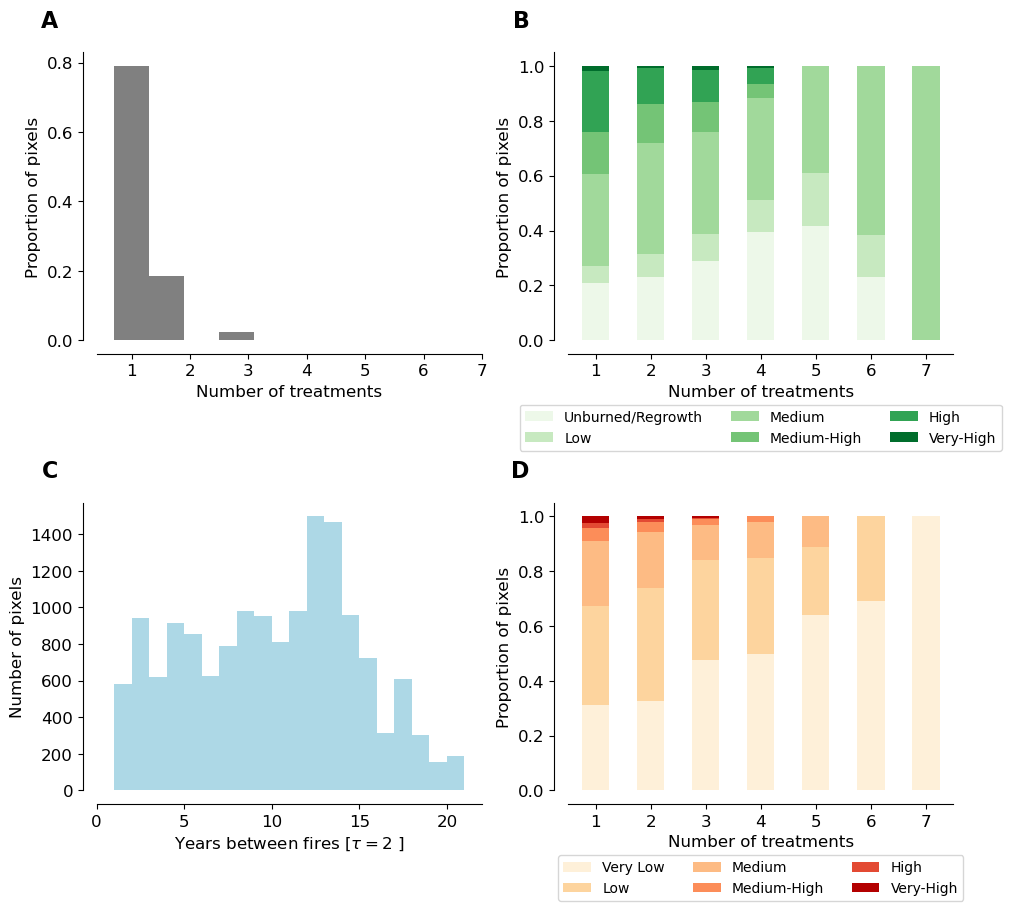

In [20]:
def delta_fire(group):
    return pd.DataFrame(
        {
            "min_year": group[group.treat == 1].year.min(),
            "max_year": group[group.treat == 1].year.max(),
            "delta_year": group[group.treat == 1].year.max()
            - group[group.treat == 1].year.min(),
        },
        index=[0],
    )


# Big figure
fig, axd = plt.subplot_mosaic(
    [["upper left", "upper right"], ["lower left", "lower right"]],
    figsize=(10, 9),
    layout="constrained",
)
g = wildfires[wildfires.count_treats == 2].groupby("grid_id")
df = g.apply(delta_fire)
df.delta_year.hist(bins=20, ax=axd["lower left"], grid=False, color="lightblue")

axd["lower left"].set_xlabel(r"Years between fires [$\tau = 2$ ]", fontsize=12)
axd["lower left"].set_ylabel("Number of pixels", fontsize=12)

# Get the proportion of pixels in each number of treatments.
df = wildfires[wildfires.count_treats > 0]

hist, bins = np.histogram(df.count_treats.values)
axd["upper left"].bar(
    bins[:-1],
    hist.astype(np.float32) / hist.sum(),
    width=(bins[1] - bins[0]),
    color="grey",
)
# Change label name in the first axis
axd["upper left"].set_xlabel("Number of treatments", fontsize=12)
axd["upper left"].set_ylabel("Proportion of pixels", fontsize=12)


# Proporiton of pixels in each FRP class
props = df.groupby(["count_treats", "first_frp"], as_index=False).grid_id.count()
props["prop"] = props.grid_id / props.groupby(["count_treats"]).grid_id.transform("sum")
props.sort_values(by=["count_treats"])

# Reshape the to have counter per first_frp columns
props = props.pivot(index="count_treats", columns="first_frp", values="prop").fillna(0)
props.columns = ["Very Low", "Low", "Medium", "Medium-High", "High", "Very-High"]

# Plot it!
props.plot.bar(
    rot=0,
    stacked=True,
    ax=axd["lower right"],
    color=["#fef0d9", "#fdd49e", "#fdbb84", "#fc8d59", "#e34a33", "#b30000"],
)

# Change legend labels
axd["lower right"].legend(
    # title="First FRP class",
    # title_fontsize="12",
    # fontsize="10",
    loc="upper center",
    bbox_to_anchor=(0.5, -0.2),
    ncol=3,
)

axd["lower right"].set_xlabel("Number of treatments", fontsize=12)
axd["lower right"].set_ylabel("Proportion of pixels", fontsize=12)


# Now do the same plot but for severity
props = df.groupby(["count_treats", "first_dnbr"], as_index=False).grid_id.count()
props["prop"] = props.grid_id / props.groupby(["count_treats"]).grid_id.transform("sum")

props = props.pivot(index="count_treats", columns="first_dnbr", values="prop").fillna(0)
props.columns = [
    "Unburned/Regrowth",
    "Low",
    "Medium",
    "Medium-High",
    "High",
    "Very-High",
]

props.plot.bar(
    rot=0,
    stacked=True,
    ax=axd["upper right"],
    color=["#edf8e9", "#c7e9c0", "#a1d99b", "#74c476", "#31a354", "#006d2c"],
)

axd["upper right"].set_xlabel("Number of treatments", fontsize=12)
axd["upper right"].set_ylabel("Proportion of pixels", fontsize=12)

# Change legend labels
axd["upper right"].legend(
    # title="First FRP class",
    # title_fontsize="12",
    # fontsize="10",
    loc="upper center",
    bbox_to_anchor=(0.5, -0.2),
    ncol=3,
)

# Loop over axis
subtitles = ["A", "B", "C", "D"]
for i, ax in enumerate(fig.axes):
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines.left.set_position(("outward", 10))
    ax.spines.bottom.set_position(("outward", 10))
    ax.yaxis.set_ticks_position("left")
    ax.xaxis.set_ticks_position("bottom")
    ax.tick_params(axis="both", which="major", labelsize=12)
    ax.text(-0.1, 1.15, subtitles[i], transform=ax.transAxes,
      fontsize=16, fontweight='bold', va='top', ha='right')

# Save plot in high resolution
plt.savefig(
    "../figs/delta_years_treatment.png",
    dpi=300,
    bbox_inches="tight",
)

### How the treatments look like? 

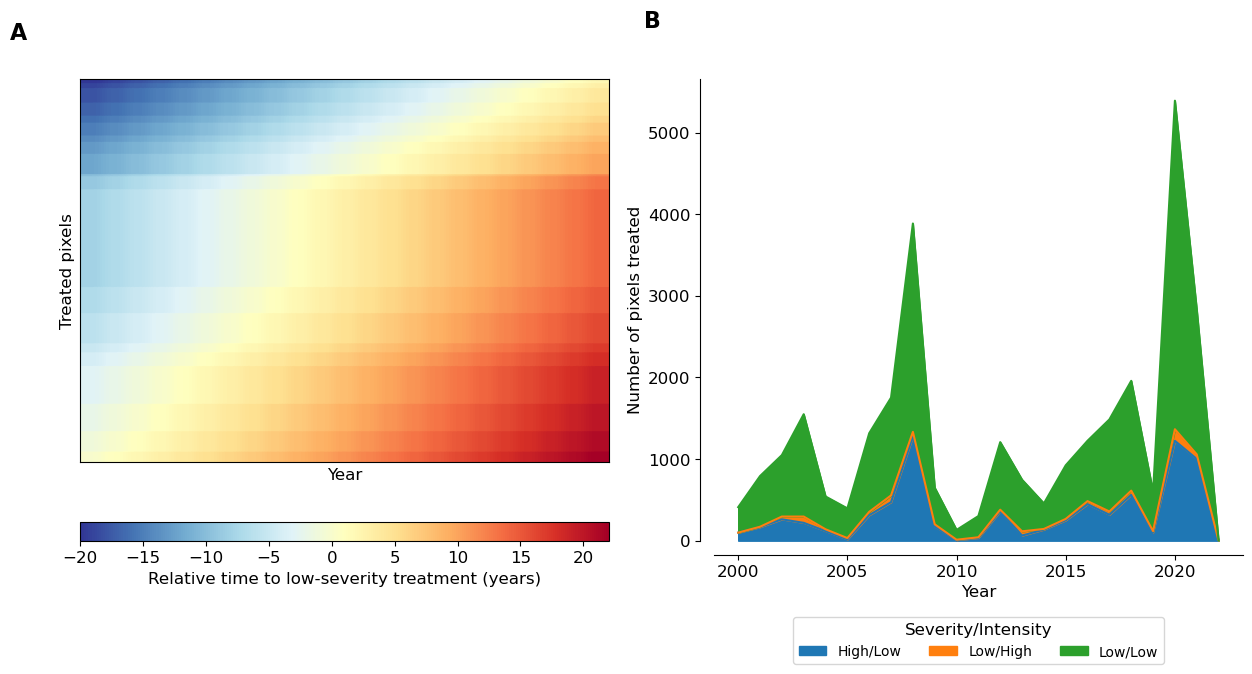

In [21]:
# Modify data frame columns for plot!
wildfires_plot = wildfires[(wildfires.count_treats == 2)].copy()
wildfires_plot["low_severity"] = np.where(wildfires_plot.first_dnbr <= 2, 1, 0)
wildfires_plot["low_intensity"] = np.where(wildfires_plot.first_frp <= 2, 1, 0)

wildfires_plot["low_severity_treat"] = (
    wildfires_plot.low_severity * wildfires_plot.treat
)
wildfires_plot["low_intensity_treat"] = (
    wildfires_plot.low_intensity * wildfires_plot.treat
)

wildfires_plot["rel_year"] = wildfires_plot["rel_year"].fillna(0)
#wildfires_plot = wildfires_plot[wildfires_plot.treat == 1]

# Pivot the dataframe to plot the heatmap as a numpy array
arr_treats = (
    wildfires_plot.pivot(index="grid_id", columns="year", values="rel_year")
    .fillna(0)
    .values
)

# Remove all rows from array that sum to zero
arr_treats = arr_treats[arr_treats.sum(axis=1) != 0]
arr_treats = arr_treats[np.argsort(arr_treats.sum(axis=1))]

# Plot treeatment assignment and relative time as a heatmap
fig, axs = plt.subplots(1, 2, figsize=(15, 6))
im = axs[0].imshow(arr_treats, aspect="auto", cmap="RdYlBu_r")

# Remove axes
axs[0].set_yticks([])
axs[0].set_xticks([])
axs[0].set_xlabel("Year", fontsize=12)
axs[0].set_ylabel("Treated pixels", fontsize=12)

for spine in plt.gca().spines.values():
    spine.set_visible(False)

#  Change position color bar to bottom of the plot
divider = make_axes_locatable(axs[0])
cax = divider.new_vertical(size="5%", pad=0.6, pack_start=True)
fig.add_axes(cax)

# Add color bar at the bottom of plot
cbar = plt.colorbar(im, cax=cax, orientation="horizontal")
cbar.set_label("Relative time to low-severity treatment (years)", fontsize=12)
cbar.ax.tick_params(labelsize=12)

# Add plot severity/intensity treatments
agg = (
    wildfires_plot.groupby(
        ["low_severity_treat", "low_intensity_treat", "year"], as_index=False
    )
    .grid_id.count()
    .pivot(
        index="year",
        columns=["low_severity_treat", "low_intensity_treat"],
        values="grid_id",
    )
)

# Plot the combination
agg.loc[:, [(0, 1), (1, 0), (1, 1)]].plot.area(ax=axs[1])

# Spine the plot in a cute way
axs[1].spines["left"].set_visible(True)
axs[1].spines["bottom"].set_visible(True)
axs[1].spines.left.set_position(("outward", 10))
axs[1].spines.bottom.set_position(("outward", 10))
axs[1].yaxis.set_ticks_position("left")
axs[1].xaxis.set_ticks_position("bottom")
axs[1].tick_params(axis="both", which="major", labelsize=12)

# Change axis labels
axs[1].set_xlabel("Year", fontsize=12)
axs[1].set_ylabel("Number of pixels treated", fontsize=12)

# Get legends from default plotting
lines, labels = axs[1].get_legend_handles_labels()

# Change legend values to coincide with the plot colors
axs[1].legend(
    labels=["High/Low", "Low/High", "Low/Low"],
    handles=lines,
    title="Severity/Intensity",
    title_fontsize="12",
    fontsize="10",
    loc="upper center",
    bbox_to_anchor=(0.5, -0.15),
    ncol=3,
)

# Loop over axis
subtitles = ["A", "B"]
for i, ax in enumerate(axs):
    ax.text(-0.1, 1.15, subtitles[i], transform=ax.transAxes,
      fontsize=16, fontweight='bold', va='top', ha='right')

# Save plot in high resolution
plt.savefig(
    "../figs/heatmap_treatments.png",
    dpi=300,
    bbox_inches="tight",
)

### Run regresions with `feols`

In [167]:
# Is low severity?
wildfires["low_severity"] = np.where(wildfires.first_frp <= 2, 1, 0)

fit_twfwe = feols(
    "frp ~  i(rel_year, ever_treated) | grid_id + year",
    wildfires[(wildfires.count_treats <= 2)],
    # i_ref1=[-1.0]
    vcov={"CRV1": "grid_id"},
)

# fit_twfwe.tidy()
fit_twfwe.iplot(
    title="TWFE-Estimator",
    coord_flip=True,
    figsize=[1200, 400],
)

/home/topcat/miniforge3/envs/prescribed/lib/python3.10/site-packages/pyfixest/feols.py:1537: UserWarning: 
            The following variables are collinear: ['C(rel_year)[T.20.0]:ever_treated' 'C(rel_year)[T.21.0]:ever_treated'].
            The variables are dropped from the model.
            
  warnings.warn(


In [268]:
fit = lpdid(
    wildfires[wildfires.dnbr >= 0],
    yname="dnbr",
    idname="grid_id",
    tname="year",
    gname="min_treat_year",
    vcov={"CRV1": "grid_id"},
    pre_window=-20,
    post_window=20,
    att=False,
)

fit.tidy().head()
fit.iplot(figsize=[1200, 400], coord_flip=False).show()

/home/topcat/miniforge3/envs/prescribed/lib/python3.10/site-packages/pyfixest/feols.py:553: RuntimeWarning: invalid value encountered in divide
  self._tstat = _beta_hat / self._se
/home/topcat/miniforge3/envs/prescribed/lib/python3.10/site-packages/pyfixest/feols.py:1194: RuntimeWarning: invalid value encountered in double_scalars
  self._r2 = 1 - (ssu / ssy)
/home/topcat/miniforge3/envs/prescribed/lib/python3.10/site-packages/pyfixest/feols.py:1195: RuntimeWarning: invalid value encountered in double_scalars
  self._adj_r2 = 1 - (ssu / ssy) * _adj_factor
/home/topcat/miniforge3/envs/prescribed/lib/python3.10/site-packages/pyfixest/feols.py:1199: RuntimeWarning: invalid value encountered in double_scalars
  self._r2_within = 1 - (ssu / ssy_within)
/home/topcat/miniforge3/envs/prescribed/lib/python3.10/site-packages/pyfixest/feols.py:1200: RuntimeWarning: invalid value encountered in double_scalars
  self._r2_adj_within = 1 - (ssu / ssy_within) * _adj_factor
/home/topcat/miniforge3/env

In [129]:
df_het[(df_het.state == 11) & (df_het.unit == 21)]

,unit,state,group,unit_fe,g,year,year_fe,treat,rel_year,rel_year_binned,error,te,te_dynamic,dep_var
620,21,11,Group 1,1.790158,2000,1990,0.066159,False,-10.0,-6,0.125942,0,0.00,1.982259
621,21,11,Group 1,1.790158,2000,1991,-0.030980,False,-9.0,-6,-1.070131,0,0.00,0.689047
622,21,11,Group 1,1.790158,2000,1992,-0.119607,False,-8.0,-6,3.523341,0,0.00,5.193891
623,21,11,Group 1,1.790158,2000,1993,0.126321,False,-7.0,-6,-0.142234,0,0.00,1.774245
624,21,11,Group 1,1.790158,2000,1994,-0.106921,False,-6.0,-6,0.006588,0,0.00,1.689825
625,21,11,Group 1,1.790158,2000,1995,-0.270420,False,-5.0,-5,-1.855259,0,0.00,-0.335521
626,21,11,Group 1,1.790158,2000,1996,0.003208,False,-4.0,-4,0.149786,0,0.00,1.943151
627,21,11,Group 1,1.790158,2000,1997,0.224162,False,-3.0,-3,-0.877656,0,0.00,1.136664
628,21,11,Group 1,1.790158,2000,1998,0.076094,False,-2.0,-2,1.003766,0,0.00,2.870018
629,21,11,Group 1,1.790158,2000,1999,0.136987,False,-1.0,-1,0.638650,0,0.00,2.565795


In [ ]:
ids = wildfires[wildfires.Incid_Name == "DIXIE"].dropna()

# dnbr from file
dnbr = pd.read_feather("/mnt/sherlock/oak/prescribed_data/processed/dnbr.feather")
dnbr = dnbr[dnbr.Event_ID == "CA3987612137920210714"]

fig, ax = plt.subplots(figsize=(20, 20))
ax.scatter(
    y=ids[["lat", "lon"]].to_numpy()[:, 0],
    x=ids[["lat", "lon"]].to_numpy()[:, 1],
    linewidth=0,
    alpha=0.7,
    s=20,
    c=ids["dnbr"].to_numpy(),
    marker=",",
)
# ax.scatter(
#     y=dnbr[["lat", "lon"]].to_numpy()[:, 0],
#     x=dnbr[["lat", "lon"]].to_numpy()[:, 1],
#     linewidth=0,
#     alpha=0.7,
#     s=10,
#     c='r',
#     marker=",",
# )

# Debug data code again!

In [269]:
mtbs = gpd.read_file(
    "/mnt/sherlock/oak/prescribed_data/geoms/mtbs_perims_DD_updated/mtbs_perims_DD.shp"
)

mtbs[
    (mtbs.Incid_Type == "Wildfire") & (mtbs.Event_ID.str.startswith("CA"))
].sort_values("BurnBndAc", ascending=False).head(20)

,Event_ID,irwinID,Incid_Name,Incid_Type,Map_ID,Map_Prog,Asmnt_Type,BurnBndAc,BurnBndLat,BurnBndLon,...,Perim_ID,dNBR_offst,dNBR_stdDv,NoData_T,IncGreen_T,Low_T,Mod_T,High_T,Comment,geometry
29307,CA3966012280920200817,EE343B88-0ADB-4C25-B744-6B4CE9DCC6DA,AUGUST COMPLEX,Wildfire,10021108,MTBS,Extended,1068802,39.94,-123.03,...,804503220201019,37,34,-970,-150,110,309,550,"CA4012512307320200818, CA4008712298420200819, ...","POLYGON ((-122.86087 39.49303, -122.86084 39.4..."
30266,CA3987612137920210714,E9DB628D-DFB7-4C85-BCD6-1254574D946B,DIXIE,Wildfire,10023957,MTBS,Extended,979795,40.323,-120.865,...,None,-14,35,-970,-150,70,304,570,Burn scar to the east was burnt slightly earli...,"MULTIPOLYGON (((-120.48410 40.27266, -120.4838..."
27410,CA3924012311020180727,25B938AB-3047-4D7B-ADE3-FD752F156F7C,RANCH,Wildfire,10014566,MTBS,Extended,427048,39.269,-122.775,...,None,-24,36,-970,-150,55,302,575,Used modified geomac perimeter.,"POLYGON ((-122.68854 39.51925, -122.68845 39.5..."
29324,CA3742412156820200816,871C357C-444E-437E-AD4D-EBDAF39C3AD6,SCU LIGHTNING COMPLEX,Wildfire,10021184,MTBS,Initial,405787,37.493,-121.5,...,None,52,43,-970,-150,90,350,640,4-4 fire is included in this complex.,"MULTIPOLYGON (((-121.86486 37.51712, -121.8644..."
29131,CA3720111927220200905,33CBB9DC-6983-4F47-B821-9C9A6CAC381D,CREEK,Wildfire,10020469,MTBS,Extended,381441,37.317,-119.214,...,None,36,36,-970,-150,65,324,610,None,"POLYGON ((-119.39124 37.15000, -119.39144 37.1..."
29266,CA4009112093120200817,6701B25B-7005-4C57-8577-96E15AC213C4,NORTH COMPLEX,Wildfire,10020999,MTBS,Extended,316556,39.725,-121.127,...,804403220201012,29,22,-970,-150,90,328,600,Complex includes Baer and Claremont fires.,"MULTIPOLYGON (((-121.42921 39.54718, -121.4286..."
29306,CA3850412233720200817,AB8C9F13-A691-48C7-8BF6-3A4A5946F0EF,HENNESSEY,Wildfire,10021102,MTBS,Extended,314241,38.623,-122.283,...,None,61,43,-970,-150,90,296,540,None,"POLYGON ((-122.49785 38.64292, -122.49793 38.6..."
18984,CA4062112015220120812,None,RUSH,Wildfire,1463,MTBS,Initial,306811,40.603,-120.09,...,None,22,-9999,-970,-150,50,302,580,None,"POLYGON ((-119.98304 40.91256, -119.98319 40.9..."
25458,CA3442911910020171205,943D8086-7DF4-47C7-BB98-A358E962667E,THOMAS,Wildfire,10008148,MTBS,Extended,281982,34.459,-119.303,...,None,6,32,-970,-150,100,300,700,Used modified GeoMac perimeter.,"POLYGON ((-119.35345 34.39726, -119.35325 34.3..."
10142,CA3293911676620031025,None,CEDAR,Wildfire,12953,MTBS,Extended,268362,32.939,-116.766,...,None,30,-9999,-970,-150,100,197,350,None,"POLYGON ((-116.94275 32.91425, -116.94309 32.9..."


In [354]:
fit_twfe = feols(
    "dnbr ~ frp | grid_id + year",
    wildfires[(wildfires.frp > 0) & (wildfires.frp < 200) & (wildfires.dnbr > 0)],
    i_ref1=[-1.0, np.inf],
)

In [353]:
fit_twfe.summary()

###

Estimation:  OLS
Dep. var.: dnbr, Fixed effects: grid_id+year
Inference:  CRV1
Observations:  41109

| Coefficient   |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5 % |   97.5 % |
|:--------------|-----------:|-------------:|----------:|-----------:|--------:|---------:|
| frp           |      0.000 |        0.000 |     9.424 |      0.000 |   0.000 |    0.000 |
---
RMSE: 0.017   R2: 0.951   R2 Within: 0.022


(43736.17914964142, 95436.17914964142, -117497.40300337225, -37197.40300337225)

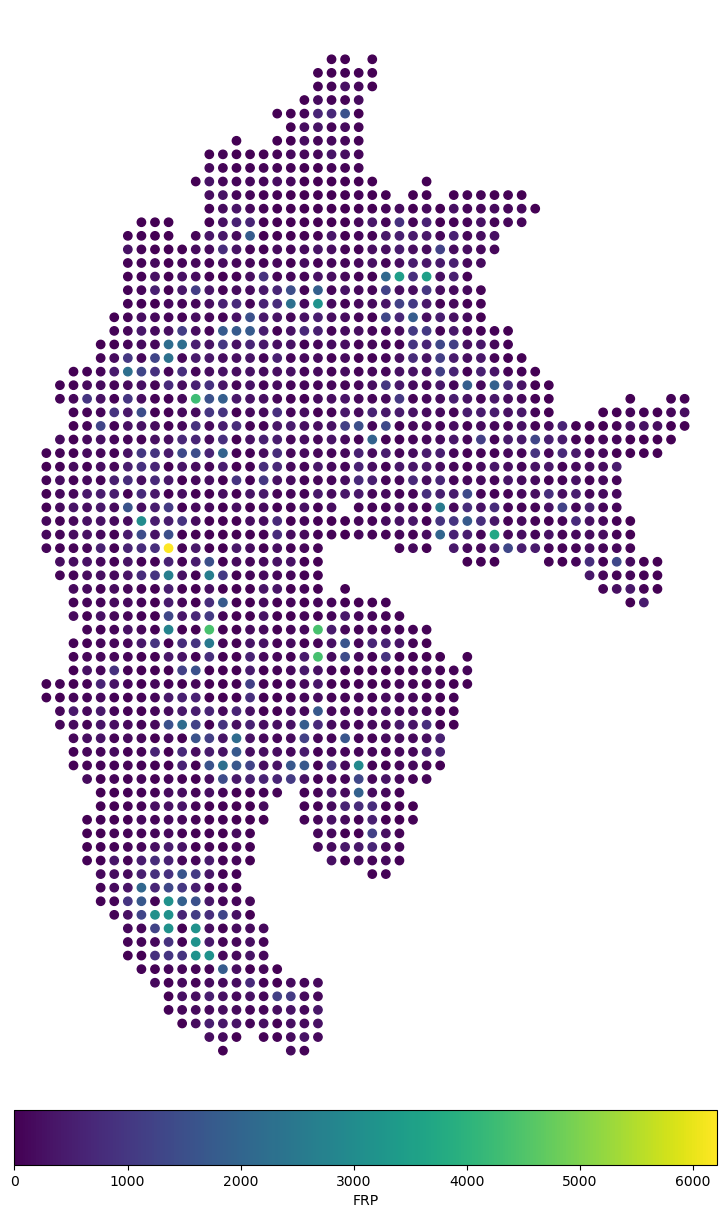

In [325]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

ids = wildfires[wildfires.Event_ID == "CA3720111927220200905"]

# Tranform ids to geopandas dataframe
ids = gpd.GeoDataFrame(ids, geometry=gpd.points_from_xy(ids.lon, ids.lat))
ids.crs = "EPSG:3310"

fig, ax = plt.subplots(figsize=(10, 15))

# Take care of the colorbar size
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.1)

# Plot with divergent color scheme
ids.plot(
    column="frp",
    legend=True,
    cmap="viridis",
    ax=ax,
    cax=cax,
    legend_kwds={"label": "FRP", "orientation": "horizontal"},
)


# # Remove the axis labels and lines
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])
ax.axis("off")


# fig, ax = plt.subplots(figsize=(5, 5))
# ax.scatter(
#     y=ids[["lat", "lon"]].to_numpy()[:, 0],
#     x=ids[["lat", "lon"]].to_numpy()[:, 1],
#     linewidth=0,
#     alpha=0.7,
#     s=20,
#     c=ids["frp"].to_numpy(),
#     marker=",",
# )

# # Remove the axis labels and lines
# ax.set_xticklabels([])
# ax.set_yticklabels([])
# ax.set_xticks([])
# ax.set_yticks([])
# ax.axis("off")

# # ax.scatter(
# #     y=dnbr[["lat", "lon"]].to_numpy()[:, 0],
# #     x=dnbr[["lat", "lon"]].to_numpy()[:, 1],
# #     linewidth=0,
# #     alpha=0.7,
# #     s=10,
# #     c='r',
# #     marker=",",
# # )

Text(0, 0.5, 'FRP')

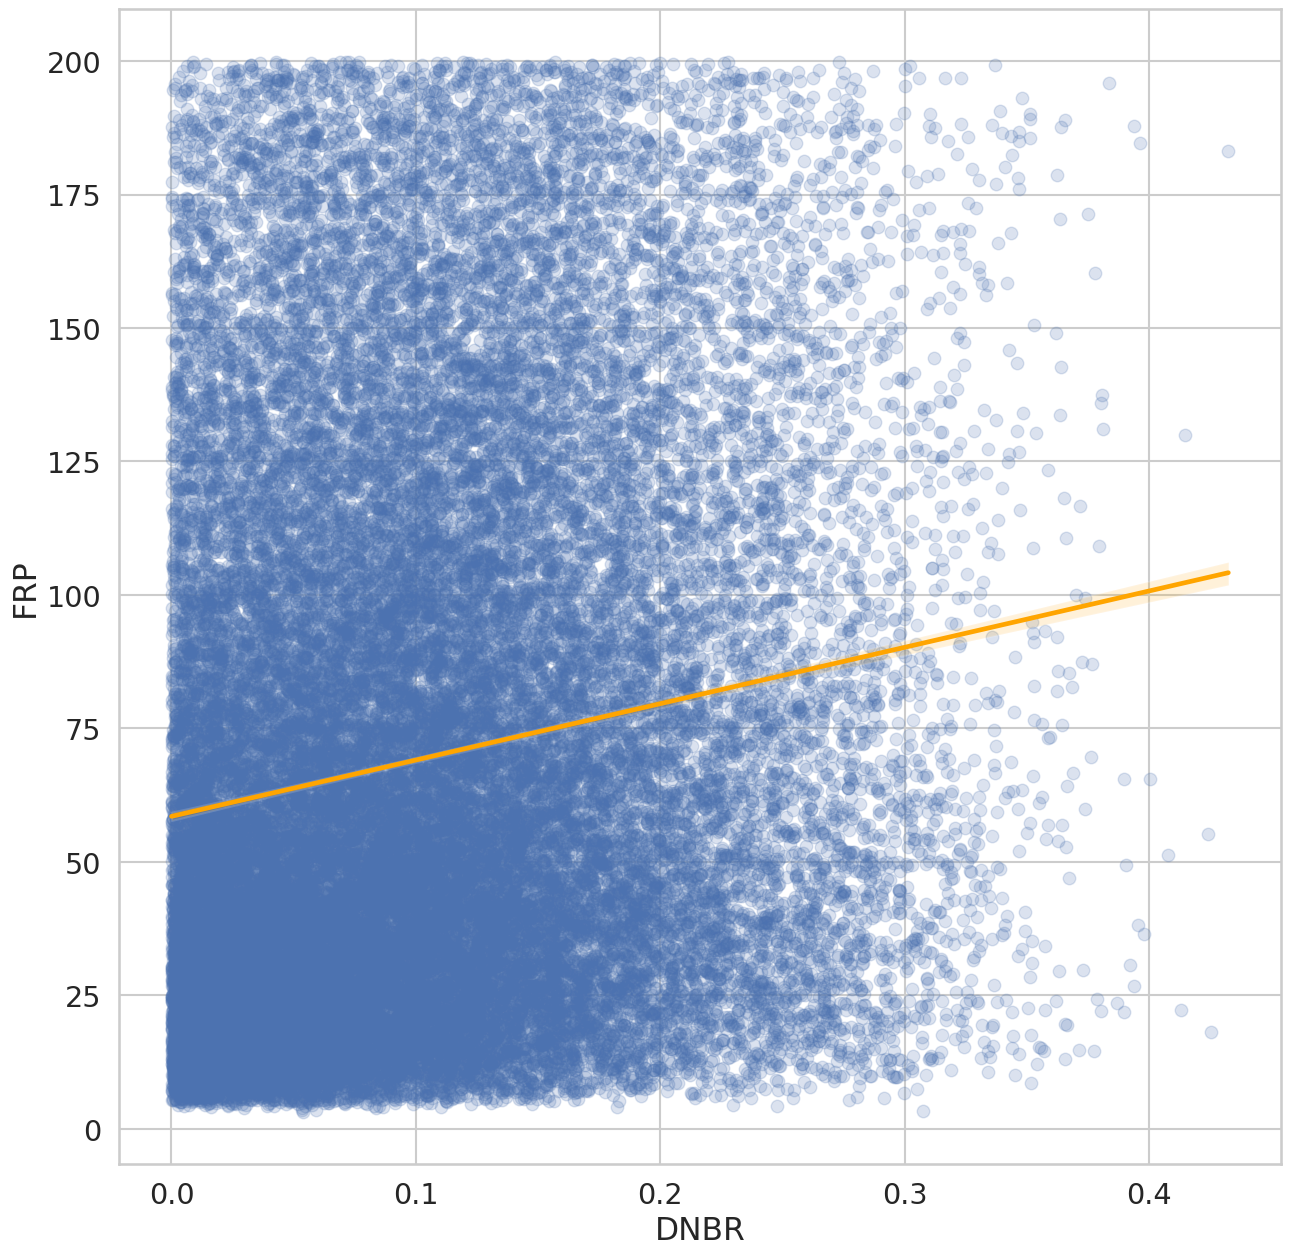

In [362]:
# increase font size of all elements
sns.set_context("talk", font_scale=1.25)
sns.set_style("whitegrid")

plt.figure(figsize=(15, 15))
sns.regplot(
    x="dnbr",
    y="frp",
    data=wildfires[(wildfires.frp > 0) & (wildfires.frp < 200) & (wildfires.dnbr > 0)],
    lowess=False,
    scatter_kws={"alpha": 0.2},
    line_kws={"color": "orange"},
)

# Change axis names
plt.xlabel("DNBR")
plt.ylabel("FRP")